 # marquises, snapshot, movies

---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from dask import delayed
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
cluster = PBSCluster(cores=12, processes=12,)
w = cluster.scale(12*4)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.135.39.57:53434 Dashboard: http://10.135.39.57:8787/status,Cluster Workers: 48 Cores: 48 Memory: 399.84 GB


---


## define a region of interest

In [6]:
region = 'marquises'
lon = [-150, -130]
lat = [-20, 0]
face = 8

#v, vmin, vmax = 'Eta', -1., 2.
#v, vmin, vmax = 'SSU', -1., 1.
v, vmin, vmax = 'SST', 23., 28.

grd = load_grd()

In [7]:
grd

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
    CS       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth    (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    PHrefC   (k) float32 dask.array<shape=(90,), chunksize=(90,)>
    PHrefF   (k_p1) float32 dask.array<shape=(91,), chunksize=(91,)>
    SN       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XG       (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YG       (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Z        (k) float32 dask.array<shape=(90,), chunksi

/home/mp/pontea/.conda/envs/equinox/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/mp/pontea/.conda/envs/equinox/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/mp/pontea/.conda/envs/equinox/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/mp/pontea/.conda/envs/equinox/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/mp/pontea/.conda/envs/equinox/lib/

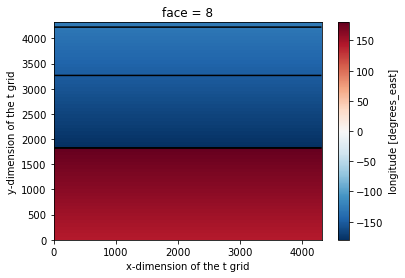

In [8]:
xc = grd.XC.isel(i=slice(0,None,4),j=slice(0,None,4), face=face)
yc = grd.YC.isel(i=slice(0,None,4),j=slice(0,None,4), face=face)

xc.plot()
xc.plot.contour(levels=lon, colors='k', linestyles='-')

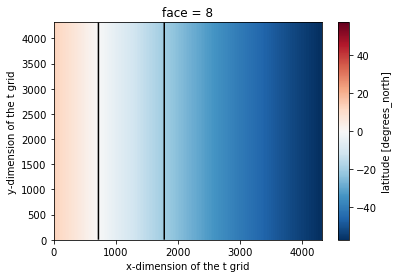

In [9]:
yc.plot()
yc.plot.contour(levels=lat, colors='k', linestyles='-')

In [10]:
islice = slice(700, 1800)
jslice = slice(3200,4200)

---

## load grid and data

In [11]:
if v in ['Eta','SST','SSS']:
    ds = load_data(v)
elif v in ['SSU','SSV']:
    dsu = load_data('SSU').rename({'i_g':'i'})
    dsv = load_data('SSV').rename({'j_g':'j'})
    ds = xr.merge([dsu, dsv])      
ds = (ds.assign_coords(XC=grd.XC, YC=grd.YC)
       .drop(['Depth','rA', 'hFacC']))

ds = ds.isel(i=islice, j=jslice, face=face)

# rotate if necessary
if v in ['SSU','SSV']:
    ds['SSU_geo'], ds['SSV_geo'] = rotate(ds.SSU, ds.SSV, ds)
    ds = ds.drop(['SSU','SSV'])
    if v is 'SSU': v = 'SSU_geo' 
    if v is 'SSV': v = 'SSV_geo' 
print(ds)
print(v)

print('\n data set (all faces): %.1f GB' %(ds.nbytes / 1e9))
print('\n variable size (all faces): %.1f GB' %(ds[v].nbytes / 1e9))
print('\n data size (1 time): %.1f GB' %(ds[v].isel(time=0).nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (i: 1100, j: 1000, time: 8785)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8785,), chunksize=(8785,)>
    face     int64 8
  * i        (i) int64 700 701 702 703 704 705 ... 1794 1795 1796 1797 1798 1799
    iters    (time) int64 dask.array<shape=(8785,), chunksize=(1,)>
  * j        (j) int64 3200 3201 3202 3203 3204 ... 4195 4196 4197 4198 4199
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 ... 3.732e+07 3.732e+07
    CS       (j, i) float32 dask.array<shape=(1000, 1100), chunksize=(1000, 1100)>
    SN       (j, i) float32 dask.array<shape=(1000, 1100), chunksize=(1000, 1100)>
    YC       (j, i) float32 dask.array<shape=(1000, 1100), chunksize=(1000, 1100)>
    XC       (j, i) float32 dask.array<shape=(1000, 1100), chunksize=(1000, 1100)>
Data variables:
    SST      (time, j, i) float32 dask.array<shape=(8785, 1000, 1100), chunksize=(1, 1000, 1100)>
SST

 data set (all faces): 38.7 GB

 variable size (all faces): 38.7 GB

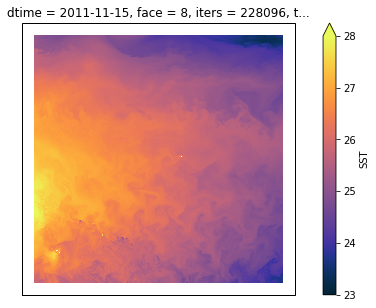

In [15]:
# plot one figure to check lon/lat treatment
dv = ds[v].isel(time=0)
# for faces that cross the date longitude
dv = dv.assign_coords(XC=((dv.XC+180.)% 360))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cmap = cm.thermal
#cmap = cm.balance
#cmap = plt.get_cmap('RdGy_r')
dv.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
        cmap=cmap)
#ax.grid()
#dv.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=3., vmax=30., cmap=cmap)
#dv.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), cmap=cmap)

---

# make movie

In [16]:
_default_cmaps = {'SSU': cm.balance, 'SSV': cm.balance,
           'SSU_geo': cm.balance, 'SSV_geo': cm.balance,
           'Eta': plt.get_cmap('RdGy_r'), 
           'SST': cm.thermal, 'SSS': cm.haline}

_region_params = {'atlantic': {'faces':[0,1,2,6,10,11,12],'extent':[-110,25,-70,70], 'projection': ccrs.Mollweide()}, 
                  'south-atlantic':{'faces':[1,11,0,12],'extent':[-50,20,-60,5],
                                    'projection': ccrs.LambertAzimuthalEqualArea(central_longitude=-15.,
                                                                                 central_latitude=-30)},
                  'south-pacific':{'faces':[8,9,11,12],'extent':[170,-80, -50, 5.],
                                    'projection': ccrs.Stereographic(central_longitude=-130.,
                                                                                 central_latitude=3.0)},
                  'marquises':{'faces':[face],'extent':lon+lat,
                                    'projection': ccrs.PlateCarree()}}

In [17]:
#import cartopy.mpl.ticker as cticker

def plot_pretty_fake(figsize=(15,15), projection=None, extent=None, region=None):

        if region is not None:
            _extent = _region_params[region]['extent']
            _projection = _region_params[region]['projection']
        else:
            _projection = ccrs.Robinson()
        if extent is not None:
            _extent = extent
        if projection is not None:
            _projection = projection
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=_projection)
        print(_extent)
        ax.set_extent(_extent)
        ax.add_feature(cfeature.LAND)
        ax.set_xticks(np.arange(_extent[0],_extent[1]+5,5*np.sign(_extent[1]-_extent[0])), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(_extent[2],_extent[3]+5,5*np.sign(_extent[3]-_extent[2])), crs=ccrs.PlateCarree())
        #lon_formatter = cticker.LongitudeFormatter()
        #lat_formatter = cticker.LatitudeFormatter()
        #ax.xaxis.set_major_formatter(lon_formatter)
        #ax.yaxis.set_major_formatter(lat_formatter)
        gl = ax.grid()
        return fig, ax
    

#fig, ax = plot_pretty_fake(region='south-atlantic')
#fig, ax = plot_pretty_fake(region='marquises')

In [18]:
#from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def _get_cmap(v, cmap):
    if cmap is None and v.name in _default_cmaps:
        return _default_cmaps[v.name] 
    else:
        return plt.get_cmap('magma')   

#                  'south-atlantic':{'faces':[0,1,11,12],'extent':[-100,25,-70,5]},}

def plot_pretty(v, colorbar=False, title=None, vmin=None, vmax=None, savefig=None, 
                offline=False, coast_resolution='110m', figsize=(15,15), cmap=None,
                ignore_face=[], projection=None, extent=None, region=None):
    #
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        colmap = _get_cmap(v, cmap)
        #
        if 'face' not in v.dims:
            v = v.expand_dims('face')
        if region is not None:
            _extent = _region_params[region]['extent']
            gen = (face for face in _region_params[region]['faces'] 
                   if face not in ignore_face)
            _projection = _region_params[region]['projection']
        else:
            gen = (face for face in v.face.values if face not in ignore_face)
            _projection = ccrs.Robinson()
        if extent is not None:
            _extent = extent
        if projection is not None:
            _projection = projection
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=_projection)
        ax.set_extent(_extent)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC>0) & (vplt.XC<179.)).plot.pcolormesh(ax=ax,
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', cmap=colmap, add_colorbar=False)
                im = vplt.where(vplt.XC<0).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', cmap=colmap, add_colorbar=False)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', cmap=colmap, add_colorbar=False)
        #
        if colorbar:
            fig.colorbar(im)
        # grid lines:
        ax.set_xticks(np.arange(_extent[0],_extent[1]+5,5*np.sign(_extent[1]-_extent[0])), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(_extent[2],_extent[3]+5,5*np.sign(_extent[3]-_extent[2])), crs=ccrs.PlateCarree())
        #gl = ax.gridlines()
        gl = ax.grid()
        #ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
        #ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
        #lon_formatter = LongitudeFormatter(zero_direction_label=True)
        #lat_formatter = LatitudeFormatter()
        #ax.xaxis.set_major_formatter(lon_formatter)
        #ax.yaxis.set_major_formatter(lat_formatter)        
        # only with platecarre
        #if projection is 'PlateCarre':
        #    gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', 
        #                    alpha=0.5, linestyle='--')
        #    gl.xlabels_top = False
        
        # coastlines and land:
        #if coast_resolution is not None:
        #    ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)
        #
        if title is not None:
            ax.set_title(title,fontdict={'fontsize':20, 'fontweight':'bold'})
        #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        #if not offline:
        #    plt.show()
        return fig, ax

In [19]:
# could delete all figures beforehand
figdir = scratch+'figs/'
print('Figures directory: '+figdir)

def genfig(ds, v, i, pretty=True, overwrite=True):
        
    # !! passing the variable does not work
    dv = ds[v]

    #time = pd.to_datetime(str(eta['time'].values))
    #time = dv['time'].values/86400.
    time = pd.to_datetime(dv['dtime'].values)
    #figname = figdir+'%s_f%d_t%05d' %(v, face, i)+'.png'
    figname = figdir+'%s_%s_t%05d' %(v, region, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        #title = 'eta %.2f' %time
        title = '%s %s' %(v, time.strftime('%Y/%m/%d %Hh'))
        if pretty:
            fig, ax = plot_pretty(dv, vmin=vmin, vmax=vmax, region=region,
                                  colorbar=True, title=title, savefig=figname,
                                  offline=True)
        else:
            figs, ax = plot_scalar(dv, vmin=vmin, vmax=vmax, 
                                   colorbar=True, title=title, savefig=figname,
                                   offline=True, coast_resolution=None, figsize=(15,10))
        #
        #m = float(dv.mean().values)
        m = 1.
    else:
        m = -1.
    return m

Figures directory: /home/mp/pontea/scratch/figs/


Process all times: does not work

Useful to see a couple of figures

In [51]:
#I = range(len(ds['time'])) # does not work
I = range(10)
values = [delayed(genfig)(ds.isel(time=i), v, i) for i in I]

In [52]:
futures = client.compute(values)
%time results = client.gather(futures)

CPU times: user 1.72 s, sys: 146 ms, total: 1.86 s
Wall time: 12.3 s


Process a selection of times

In [20]:
#II = np.array_split(np.arange(len(ds['time'])),len(ds['time'])/20) # 4 maybe will work
rg = range(6000,8000)
#II = np.array_split(rg,len(rg)/20) # 4 maybe will work
II = np.array_split(rg,len(rg)/12/4) # 12*4 corresponds to the number of workers
print('%d loops to be done'%len(II))
for I in II:
    print('%d - %d'%(I[0],I[-1]))
    #lds = ds.isel(time=slice(I[0],I[-1]+1))
    #values = [delayed(genfig)(lds.isel(time=i), v, I[i]) for i in range(len(I))]
    values = [delayed(genfig)(ds.isel(time=i), v, i, overwrite=False) for i in I]    
    futures = client.compute(values)
    %time results = client.gather(futures)

41 loops to be done
6000 - 6048
CPU times: user 8.23 s, sys: 272 ms, total: 8.5 s
Wall time: 18.9 s
6049 - 6097
CPU times: user 8.14 s, sys: 238 ms, total: 8.38 s
Wall time: 16.4 s
6098 - 6146
CPU times: user 8.23 s, sys: 244 ms, total: 8.47 s
Wall time: 16 s
6147 - 6195
CPU times: user 8.22 s, sys: 248 ms, total: 8.47 s
Wall time: 17.4 s
6196 - 6244
CPU times: user 8.17 s, sys: 216 ms, total: 8.39 s
Wall time: 16.6 s
6245 - 6293
CPU times: user 8.35 s, sys: 215 ms, total: 8.57 s
Wall time: 16.2 s
6294 - 6342
CPU times: user 8.22 s, sys: 239 ms, total: 8.46 s
Wall time: 17.5 s
6343 - 6391
CPU times: user 8.09 s, sys: 205 ms, total: 8.29 s
Wall time: 15.5 s
6392 - 6440
CPU times: user 8.54 s, sys: 256 ms, total: 8.8 s
Wall time: 18.2 s
6441 - 6489
CPU times: user 8.05 s, sys: 202 ms, total: 8.25 s
Wall time: 16.1 s
6490 - 6538
CPU times: user 8.29 s, sys: 219 ms, total: 8.5 s
Wall time: 18 s
6539 - 6587
CPU times: user 8.18 s, sys: 236 ms, total: 8.42 s
Wall time: 17.7 s
6588 - 6636
CPU

In [18]:
client.restart()

Worker tcp://10.135.36.87:41937 restart in Job 7833055. This can be due to memory issue.
Worker tcp://10.135.36.88:43250 restart in Job 7833056. This can be due to memory issue.
Worker tcp://10.135.36.85:43709 restart in Job 7833053. This can be due to memory issue.
Worker tcp://10.135.36.86:35217 restart in Job 7833054. This can be due to memory issue.


Client Scheduler: tcp://10.135.39.57:39853 Dashboard: http://10.135.39.57:8787/status,Cluster Workers: 48 Cores: 48 Memory: 399.84 GB


In [21]:
cluster.close()

Future exception was never retrieved
future: <Future finished exception=OSError("Timed out trying to connect to 'tcp://10.135.36.125:42680' after 10 s: in <distributed.comm.tcp.TCPConnector object at 0x2b96919c2b38>: ConnectionRefusedError: [Errno 111] Connection refused")>
Traceback (most recent call last):
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/distributed/comm/tcp.py", line 359, in connect
    ip, port, max_buffer_size=MAX_BUFFER_SIZE, **kwargs
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/tornado/gen.py", line 735, in run
    value = future.result()
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/tornado/tcpclient.py", line 280, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
  File "/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/tornado/tcpclient.py", line 143, in on_connect_done
    stream = future.result()
tornado.iostream.StreamClosedError: Stream

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client


---

### another strategy: load data in each loop

In [24]:
# could delete all figures beforehand
figdir = scratch+'figs/'
print('Figures directory: '+figdir)

def load_and_genfig(v, i, pretty=True, overwrite=True):
    
    region = 'south-atlantic'
    figname = figdir+'%s_%s_t%05d' %(v, region, i)+'.png'

    if not os.path.isfile(figname) or overwrite:

        grd = load_grd()
        if v in ['Eta','SST','SSS']:
            ds = load_data(v).isel(time=i)
        elif v in ['SSU','SSV','SSU_geo','SSV_geo']:
            dsu = load_data('SSU').rename({'i_g':'i'}).isel(time=i)
            dsv = load_data('SSV').rename({'j_g':'j'}).isel(time=i)
            ds = xr.merge([dsu, dsv])      
        ds = (ds.assign_coords(XC=grd.XC, YC=grd.YC)
               .drop(['Depth','rA', 'hFacC']))

        # rotate if necessary
        if v in ['SSU','SSV','SSU_geo','SSV_geo']:
            ds['SSU_geo'], ds['SSV_geo'] = rotate(ds.SSU, ds.SSV, ds)
            ds = ds.drop(['SSU','SSV'])
            if v is 'SSU': v = 'SSU_geo' 
            if v is 'SSV': v = 'SSV_geo'

        dv = ds[v]    
        time = pd.to_datetime(dv['dtime'].values)
        #title = 'eta %.2f' %time
        title = '%s %s' %(v, time.strftime('%Y/%m/%d %Hh'))
        
        if pretty:
            fig, ax = plot_pretty(dv, vmin=vmin, vmax=vmax, region=region,
                                  colorbar=False, title=title, savefig=figname,
                                  offline=True)
        else:
            figs, ax = plot_scalar(dv, vmin=vmin, vmax=vmax, 
                                   colorbar=False, title=title, savefig=figname,
                                   offline=True, coast_resolution=None, figsize=(15,10))
        #
        #m = float(dv.mean().values)
        m = 1.
    else:
        m = -1.
    return m

Figures directory: /home/mp/pontea/scratch/figs/


In [ ]:
#II = np.array_split(np.arange(len(ds['time'])),len(ds['time'])/20) # 4 maybe will work
rg = range(6000,8000)
II = np.array_split(rg,len(rg)/20) # 4 maybe will work
print('%d loops to be done'%len(II))
I = II[0]
print('%d - %d'%(I[0],I[-1]))
values = [delayed(load_and_genfig)(v, i) for i in I]    
futures = client.compute(values)
%time results = client.gather(futures)

In [11]:
#II = np.array_split(np.arange(len(ds['time'])),len(ds['time'])/20) # 4 maybe will work
rg = range(6000,8000)
II = np.array_split(rg,len(rg)/20) # 4 maybe will work
print('%d loops to be done'%len(II))
for I in II:
    print('%d - %d'%(I[0],I[-1]))
    values = [delayed(load_and_genfig)(v, i) for i in I]    
    futures = client.compute(values)
    %time results = client.gather(futures)

100 loops to be done
6000 - 6019
CPU times: user 1min 15s, sys: 4.26 s, total: 1min 20s
Wall time: 2min 45s
6020 - 6039
CPU times: user 1min 9s, sys: 3.75 s, total: 1min 13s
Wall time: 2min 37s
6040 - 6059
CPU times: user 1min 10s, sys: 4.17 s, total: 1min 14s
Wall time: 2min 44s
6060 - 6079
CPU times: user 1min 11s, sys: 4.32 s, total: 1min 16s
Wall time: 2min 44s
6080 - 6099
CPU times: user 1min 11s, sys: 4.25 s, total: 1min 15s
Wall time: 2min 38s
6100 - 6119
CPU times: user 1min 11s, sys: 4.26 s, total: 1min 15s
Wall time: 2min 43s
6120 - 6139
CPU times: user 1min 8s, sys: 4.12 s, total: 1min 12s
Wall time: 2min 40s
6140 - 6159
CPU times: user 1min 12s, sys: 4.45 s, total: 1min 16s
Wall time: 2min 47s
6160 - 6179
CPU times: user 1min 16s, sys: 4.78 s, total: 1min 21s
Wall time: 2min 49s
6180 - 6199
CPU times: user 1min 12s, sys: 4.35 s, total: 1min 17s
Wall time: 2min 47s
6200 - 6219
CPU times: user 1min 10s, sys: 4.04 s, total: 1min 14s
Wall time: 2min 40s
6220 - 6239
CPU times: u

CPU times: user 1min 13s, sys: 4.25 s, total: 1min 17s
Wall time: 2min 46s
7920 - 7939
CPU times: user 1min 14s, sys: 4.4 s, total: 1min 19s
Wall time: 2min 54s
7940 - 7959
CPU times: user 1min 14s, sys: 4.43 s, total: 1min 19s
Wall time: 2min 55s
7960 - 7979
CPU times: user 1min 13s, sys: 4.4 s, total: 1min 17s
Wall time: 2min 45s
7980 - 7999
CPU times: user 1min 11s, sys: 4.19 s, total: 1min 15s
Wall time: 2min 40s


In [12]:
cluster.close()

```
ffmpeg -f image2 -r 20 -pattern_type glob -i "./figs/*_t00*.png" -q:v 1 ./out.mp4
```

---

# individual figures

(for colormaps ...)

In [ ]:
fig, ax = plot_pretty(ds[v].isel(time=0), vmin=vmin, vmax=vmax, region=region,
                      title=v, colorbar=True)

---

# info, shutdown

In [55]:
cluster.close()

In [ ]:
client.restart()